# Persistent Scatterer (PS) selection based on phase similarity between nearby pixels

This notebook demonstrates how to use the phase similarity PS selection algorithm to identify PS pxiels from a set of Sentinel-1 interferograms.

**Reference** The detailed algorithms can be found in the following paper:

Wang K. and J. Chen, A New Persistent Scatterer Selection Algorithm Based on Phase Similarity of Radar Pixels, in IEEE Transactions on Geoscience and Remote Sensing, (in review).

## Table of Contents
+ [Setup](#Setup)
+ [Input Data](#Specify-the-input-data)
+ [Preliminary PS Candidates Selection](#Preliminary-PS-candidates-selection)
+ [Refine PS set based on phase similarity](#Refine-PS-set-based-on-phase-similarity)
+ [Expand PS set based on phase similarity](#Expand-PS-set-based-on-phase-similarity)
+ [Determine the maximum phase similarity threshold](#Determine-the-maximum-phase-similarity-threshold)

# Setup

In [2]:
from psps import sario, scr, similarity

import glob
import os
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['image.interpolation'] = 'none'

nrow,ncol = 600,600 # number of rows and columns in each interferogram
amp_disp_thr = 0.4  # threshold of amplitude dispersion (used in the MLE method)
scr_thr = 2         # threshold of Signal-to-Clutter-Ratio (used for
                    # preliminary PS selection before phase similarity
                    # calculation)
med_sim_thr = 0.3   # threshold of median phase similarity to remove false
                    # positive PS detections from the initial PS set

# where to save the scr/similarity files
output_dir = 'ps_data'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
WHITE = np.array([255,255,255])
RED = np.array([255,0,0])
GREEN = np.array([0,255,0])

# Specify the input data

In this demo, the algorithm is demonstrated on 93 Sentinel-1 SAR images (Path:143, Frame:192) acquired between 2017 and 2020 over the Greater Houston area. To reduce the size of test data, for each Sentinel-1 image, we only cropped a small patch northwest of Houston. Using the SAR image acquired on January 15, 2018 as the reference image, we formed 92 common reference intererograms (100-m pixel spacing, stored in 'data/igrams/'). We also provided the amplitude values of the SAR images in 'data/amplitude' for the calculation of amplitude dispersion. Note that the amplitude images are not required inputs for the PS selection if users decide to define their own preliminary PS candidates.

In [3]:
# list of SAR amplitude files
amplist = glob.glob('data/amplitude/*.amp')
# list of interferograms
ifglist = glob.glob('data/igrams/*.int')

# Preliminary PS candidates selection

In this demo, we used the Maximum Likelihood Estimation (MLE) algorithm for preliminary PS candidates selection. The algorithm details can be found in the following reference paper:

Shanker, P., and Zebker, H. (2007), Persistent scatterer selection using maximum likelihood estimation, Geophys. Res. Lett., 34, L22301, doi:10.1029/2007GL030806.

Note that the user can also provide their own preliminary PS candidates set `ps0`. `ps0` must be a 2D boolean array (nrow x ncol), where `ps[i,j]` is `True` if and only if the pixel `(i,j)` is a PS candidate.

In [4]:
# display the description of scr.cal_scr, which is the main function for signal-to-clutter ratio (SCR) calculation
help(scr.cal_scr)

Help on function cal_scr in module psps.scr:

cal_scr(ifglist, nrow, ncol, ntilerow=1, ntilecol=1, windowsize=11, candidate_mask=None, model='constant', output_dir='ps_data')
    Calculate signal to clutter ratio based on a list of interferograms over the
    same area. In case of large interferograms, set ntilerow and ntilecol
    greater than 1. The interferogram will be partitioned into ntilerow x
    ntilecol tiles and processed them separately.
    
    Parameters
    ----------
    ifglist: list of str
        list of interferograms
    nrow: int
        number of rows of each interferogram
    ncol: int
        number of columns of each interferogram
    ntilerow: int (optional, default:1)
        number of rows of tiles
    ntilecol: int (optional, default:1)
        number of columns of tiles 
    windowsize: int (optional, default: 11)
        size of the box-car window to estimate the local average phase
    candidate_mask: 2d boolean array (optional)
        candidate_mask[

In [5]:
# Calculate amplitude dispersion from amplitude files
print('Calculate amplitude dispersion from amplitude files')
amp_disp = scr.amp_dispersion(amplist,nrow,ncol)
amp_disp.tofile(os.path.join(output_dir,'amp_disp'))
print(f'Amplitude dispersion values have been saved to {output_dir}/amp_disp')

# calculate SCR
print('Calculate Signal-to-Clutter Ratio (SCR)')
scr_val = scr.cal_scr(ifglist,
                      nrow,
                      ncol,
                      ntilerow=2,
                      ntilecol=2,
                      windowsize = 11, 
                      candidate_mask=(amp_disp<amp_disp_thr),
                      model='constant',
                      output_dir=output_dir)
scr_val.tofile(os.path.join(output_dir,'scr'))
print(f'scr values have been saved to {output_dir}/scr')
# preliminary PS candidates
ps0 = scr_val > scr_thr

Calculate amplitude dispersion from amplitude files
Amplitude dispersion values have been saved to ps_data/amp_disp
Calculate Signal-to-Clutter Ratio (SCR)
data/igrams/20170201_20180115.int
data/igrams/20170213_20180115.int
data/igrams/20170225_20180115.int
data/igrams/20170309_20180115.int
data/igrams/20170321_20180115.int
data/igrams/20170402_20180115.int
data/igrams/20170414_20180115.int
data/igrams/20170426_20180115.int
data/igrams/20170508_20180115.int
data/igrams/20170520_20180115.int
data/igrams/20170601_20180115.int
data/igrams/20170613_20180115.int
data/igrams/20170625_20180115.int
data/igrams/20170707_20180115.int
data/igrams/20170719_20180115.int
data/igrams/20170731_20180115.int
data/igrams/20170812_20180115.int
data/igrams/20170824_20180115.int
data/igrams/20170905_20180115.int
data/igrams/20170917_20180115.int
data/igrams/20170929_20180115.int
data/igrams/20171011_20180115.int
data/igrams/20171023_20180115.int
data/igrams/20171104_20180115.int
data/igrams/20171116_2018011

Number of Preliminary PS candidates: 6820


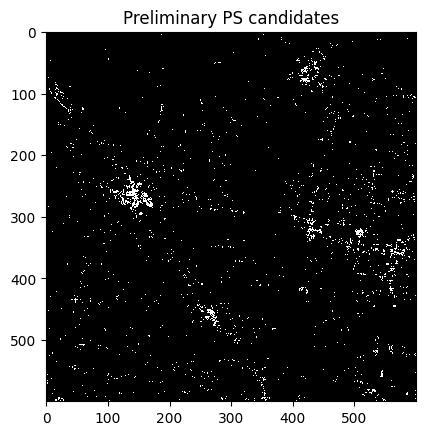

In [6]:
nps0 = np.sum(ps0)
print(f'Number of Preliminary PS candidates: {nps0}')
img = np.outer(ps0,WHITE).reshape(nrow,ncol,3)
fig,ax = plt.subplots()
ax.imshow(img)
ax.set_title('Preliminary PS candidates')
plt.show()

# Refine PS set based on phase similarity

Remove potential false positive PS pixels in the preliminary PS candidates. See the help information on function `median_similarity`. Note that the parameter `rdmin` is set by default to 3 to avoid calculating the phase similairty between adjacent radar pixels. Adjacent radar pixels sometimes may have very high phase similairty when they are interpolated from the same pixel during resampling or coregistration.

In [7]:
help(similarity.median_similarity)

Help on function median_similarity in module psps.similarity:

median_similarity(ifglist, nrow, ncol, ps0, ntilerow=1, ntilecol=1, N=20, rdmin=3, rdmax=50)
    For each PS pixel, median_similarity compute its phase similarity with
    nearby PS and return the median of similarity measurements
    
    Parameters
    ----------
    ifglist: list of str
        list of interferograms
    nrow: int
        number of rows of each interferogram
    ncol: int
        number of columns of each interferogram
    ps0 : 2D boolean array (nrow x ncol)
        PS mask: ps0[i,j] = True if pixel (i,j) is a PS pixel
    ntilerow: int (optional, default:1)
        number of rows of tiles
    ntilecol: int (optional, default:1)
        number of columns of tiles 
    N : int
        number of neighbor PS candidates used for median phase similarity
        calculation
    rdmin : int (optional, default:3)
        minimum search radius: PS pixels with distance <= rdmin to the center
        pixel are exc

Calculate median phase similarity
processing row 1/1, column 1/1
600 600

++++++++++++++++++++++++++++++++++++++++++++++
False positive PS candidates are marked in red.
++++++++++++++++++++++++++++++++++++++++++++++


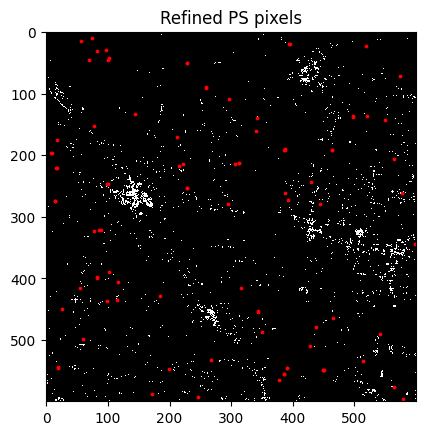

In [8]:
# refine PS set based on phase similarity
print('Calculate median phase similarity')
med_sim = similarity.median_similarity(
          ifglist,nrow,ncol,ps0=ps0,N=20,rdmin=3,rdmax=50)
ps_refined = med_sim > med_sim_thr

# Plot refined PS set
print()
print('++++++++++++++++++++++++++++++++++++++++++++++')
print('False positive PS candidates are marked in red.')
print('++++++++++++++++++++++++++++++++++++++++++++++')
fig,ax = plt.subplots()
ii_false_pos,jj_false_pos = np.where(ps0&(~ps_refined))
img = np.outer(ps0,WHITE).reshape(nrow,ncol,3)
ax.imshow(img)
ax.scatter(jj_false_pos,ii_false_pos,s=3,c='red')
ax.set_title('Refined PS pixels')
plt.show()

# Expand PS set based on phase similarity

Add new pixels that show high phase similarity with previously selected PS pixels. The maximum phase similarity threhold `max_sim_thr` ($s_{\mathrm{thr,max}}$ in the original paper) is required for this step. Here we set `max_sim_thr` to a predefined value for the conciseness of the PS selection work flow. The details on how to select this threshold can be found in [the next section](#Determine-the-maximum-phase-similarity-threshold). The help information on function max_similarity is shown below.

In [12]:
help(similarity.max_similarity)

Help on function max_similarity in module psps.similarity:

max_similarity(ifglist, nrow, ncol, ps0, ntilerow=1, ntilecol=1, threshold=0.5, N=20, rdmin=3, rdmax=50, maxiter=20)
    Find all pixels with similar phase time series to previously selected PS
    pixels based on a similarity threshold `threshold`. The function runs
    iteratively. At each iteration, non-PS pixels within a radius of rdmax
    around PS pixels identified in the previous iteration are explored. 
    
    Parameters
    ----------
    ifglist: list of str
        list of interferograms
    nrow: int
        number of rows of each interferogram
    ncol: int
        number of columns of each interferogram
    ntilerow: int (optional, default:1)
        number of rows of tiles
    ntilecol: int (optional, default:1)
        number of columns of tiles 
    ps0 : 2D boolean array (nrow x ncol)
        PS mask: ps0[i,j] = True if pixel (i,j) is a PS pixel
    threshold : float (optional, default:0.5)
        similar

Calculate maximum phase similarity
processing row 1/1, column 1/1
600 600
calculating max similarity iterate 0
calculating max similarity iterate 1
calculating max similarity iterate 2
calculating max similarity iterate 3
calculating max similarity iterate 4
calculating max similarity iterate 5
calculating max similarity iterate 6
calculating max similarity iterate 7
calculating max similarity iterate 8
calculating max similarity iterate 9
calculating max similarity iterate 10
calculating max similarity iterate 11
scr values have been saved to ps_data/max_sim

++++++++++++++++++++++++++++++++++++++++++++++
False negative PS pixels are marked in green.
++++++++++++++++++++++++++++++++++++++++++++++


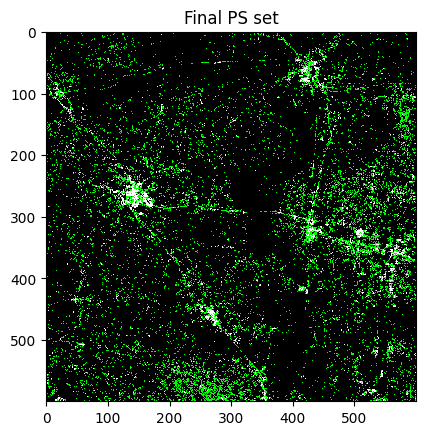

In [11]:
# set the maximum phase similarity threshold
max_sim_thr = 0.38436189413070654
print('Calculate maximum phase similarity')
max_sim = similarity.max_similarity(
          ifglist,nrow,ncol,ps0=ps_refined,threshold=max_sim_thr,N=20,rdmin=3,rdmax=50)
max_sim.tofile(os.path.join(output_dir,'max_sim'))
print('scr values have been saved to '+os.path.join(output_dir,'max_sim'))
ps_final = max_sim > max_sim_thr

# Plot the final PS set
print()
print('++++++++++++++++++++++++++++++++++++++++++++++')
print('False negative PS pixels are marked in green.')
print('++++++++++++++++++++++++++++++++++++++++++++++')
fig,ax = plt.subplots()
img = (np.outer(ps_refined,WHITE) + \
       np.outer(~ps_refined & ps_final,GREEN)).reshape(nrow,ncol,3)
ax.imshow(img)
ax.set_title('Final PS set')
plt.show()

# Determine the maximum phase similarity threshold

In this demo, we determine the maximum phase similarity threshold `max_sim_thr` (or $s_{\mathrm{thr,max}}$) based on the phase similarity statistics of a set of calibration (Non-PS) pixels. Corresponding algorithm was described in detail in the original paper. Here the pixels with the lowest 1$\%$ average InSAR phase correlation are selected as calibration pixels. Alternatively, water pixels from a land-cover classification map can be used as calibration pixels. Users can also skip this threshold selection calculation and set `max_sim_thr` mannually (0.5 is a good threshold value for the first try).

InSAR phase correlation threshold: 0.09392744965851307


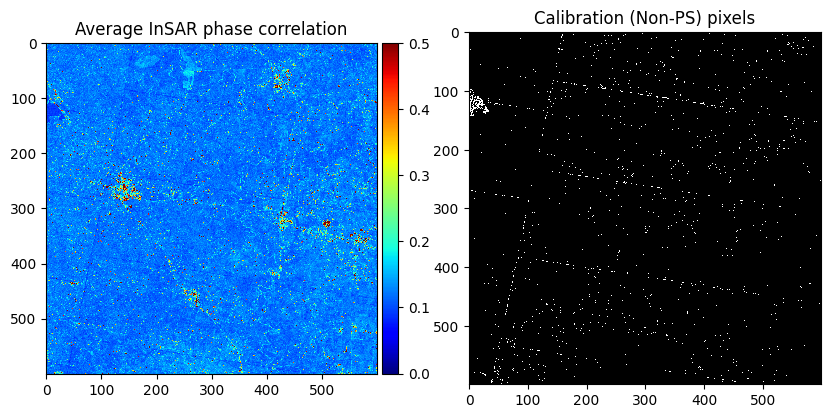

In [13]:
# Selection calibration (Non-PS) pixels based on average
# InSAR phase correlation
alpha = 0.01        # maximum acceptable false positive rate (to determine
                    # the treshold used in maximum phase similarity
                    # calculation)

# file to read the average InSAR phase correlation
avg_corr_file = 'data/correlation/avg_correlation'
# read in average InSAR phase correlation
avg_corr = np.fromfile(avg_corr_file,dtype=np.float32).reshape((nrow,ncol))
# calculate the 1st percentile of 'avg_corr'
avg_corr_thr = np.percentile(avg_corr,1)
print(f'InSAR phase correlation threshold: {avg_corr_thr}')
# calculate a mask of calibration (non-PS) pixels 
nonps = avg_corr < avg_corr_thr

# Display average InSAR phase correlation image and calibration
# (Non-PS) pixels
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,axs = plt.subplots(1,2,figsize=(10,5))

im = axs[0].imshow(avg_corr,vmin=0,vmax=0.5,cmap='jet')
axs[0].set_title('Average InSAR phase correlation')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

axs[1].imshow(nonps,cmap='gray')
axs[1].set_title('Calibration (Non-PS) pixels')
plt.show()

In [14]:
help(similarity.nonps_similarity)

Help on function nonps_similarity in module psps.similarity:

nonps_similarity(ifglist, nrow, ncol, nonps, ntilerow=1, ntilecol=1, rdmin=3, rdmax=50)
    Calculates the maximum phase similarity threshold distribution for non-PS
    pixels
    
    Parameters
    ----------
    ifglist: list of str
        list of interferograms
    nrow: int
        number of rows of each interferogram
    ncol: int
        number of columns of each interferogram
    nonps : 2D boolean array (nrow x ncol)
        mask of calibration pixels: nonps[i,j] = True if pixel (i,j) is a
        calibration non-PS pixel
    ntilerow: int (optional, default:1)
        number of rows of tiles
    ntilecol: int (optional, default:1)
        number of columns of tiles 
    rdmin : int
        minimum search radius: PS pixels with distance <= rdmin to the center
        pixel are excluded for similarity calculation
    rdmax : int
        maximum search radius: PS pixels with distance > rdmax to the center
        pi

Estimate the threshold used for maximum phase similarity calculation
processing row 1/1, column 1/1
600 600
calculating max similarity iterate 0
The estimated threshold is 0.38436189413070654


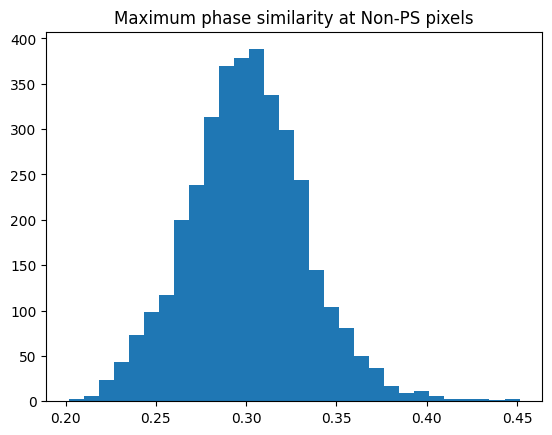

In [15]:
print('Estimate the threshold used for maximum phase similarity calculation')
nonps_sim = similarity.nonps_similarity(ifglist,nrow,ncol,nonps)
sim_thr = np.percentile(nonps_sim[nonps],(1-alpha)*100)
print(f'The estimated threshold is {sim_thr}')

# plot the histogram of maximum phase similarity at Non-PS pixels
fig,ax = plt.subplots()
ax.hist(nonps_sim[nonps],bins=30)
ax.set_title('Maximum phase similarity at Non-PS pixels')
plt.show()